In [1]:
!pip install --upgrade -q https://storage.googleapis.com/jax-wheels/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-0.1.8-cp36-none-linux_x86_64.whl
!pip install --upgrade -q jax

ERROR: jaxlib-0.1.8-cp36-none-linux_x86_64.whl is not a supported wheel on this platform.
     |████████████████████████████████| 708 kB 35.2 MB/s 


In [2]:
import matplotlib.pyplot as plt

from __future__ import print_function, division
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import numpy as onp
import time as time_time
# # JAX is a package, by the same author of the paper, for speeding up 
# # linear algebra-heavy operations

In [3]:
# Generate randomness

def keygen(key, nkeys):
  """Generate randomness that JAX can use by splitting the JAX keys.
  Args:
    key : the random.PRNGKey for JAX
    nkeys : how many keys in key generator
  Returns:
    2-tuple (new key for further generators, key generator)
  """
  keys = random.split(key, nkeys+1)
  return keys[0], (k for k in keys[1:])

In [4]:
# # Some plotting helper functions

# def print_force(params, fparams, x_t, h_t, z_t, f_t, T):
#   """Plot activations and outputs for the Echostate network run."""
#   ntoplot = 10
#   plt.figure(figsize=(16,16))

#   plt.subplot(321)
#   plt.plot(time, f_t + 2*onp.arange(0, f_t.shape[1]), 'g')
#   plt.plot(time, z_t + 2*onp.arange(0, z_t.shape[1]), 'r');
#   plt.xlim((0, T))
#   plt.title('Target - f (green), Output - z (red)')
#   plt.xlabel('Time')
#   plt.ylabel('Dimension')

#   plt.subplot(122)
#   plt.imshow(h_t.T, interpolation=None)
#   plt.title('Hidden activations of ESN')
#   plt.xlabel('Time')
#   plt.ylabel('Dimension')

#   plt.subplot(323)
#   plt.plot(time, h_t[:, 0:ntoplot] + 2*onp.arange(0, ntoplot), 'b')
#   plt.xlim((0, T))
#   plt.title('%d hidden activations of ESN'%(ntoplot))
#   plt.xlabel('Time')
#   plt.ylabel('Dimension')

#   plt.subplot(325)
#   plt.plot(time, onp.sqrt(onp.square(z_t - f_t)), 'c')
#   plt.xlim((0, T))
#   plt.title('Error - mean absolute error')
#   plt.xlabel('Time')
#   plt.ylabel('Error')

# def plot_params(params):
#   """Plot some of the parameters associated with the ESN."""
#   plt.figure(figsize=(16,10))
#   plt.subplot(221)
#   plt.imshow(params['wR'] + onp.dot(params['wF'], params['wO']), 
#             interpolation=None); 
#   plt.colorbar()
#   plt.title('Effective matrix - wR + wF wO')

#   plt.subplot(222)
#   if params['wO'].shape[0] == 1:
#     plt.stem(params['wO'][0,:])
#   else:
#     plt.imshow(params['wO'], interpolation=None)
#     plt.colorbar()
#   plt.title('Readout weights - wO');

#   x_circ = onp.linspace(-1, 1, 1000)
#   y_circ = onp.sqrt(1-x_circ**2)
#   evals, _ = onp.linalg.eig(params['wR'])
#   plt.subplot(223)
#   plt.plot(onp.real(evals), onp.imag(evals), 'o')
#   plt.plot(x_circ, y_circ, 'k')
#   plt.plot(x_circ, -y_circ, 'k')
#   plt.axis('equal')
#   plt.title('Eigenvalues of wR')

#   evals, _ = onp.linalg.eig(params['wR'] + onp.dot(params['wF'], params['wO']))
#   plt.subplot(224)
#   plt.plot(onp.real(evals), onp.imag(evals), 'o', color='orange')
#   plt.plot(x_circ, y_circ, 'k')
#   plt.plot(x_circ, -y_circ, 'k')
#   plt.axis('equal');
#   plt.title('Eigenvalues of wR + wF wO');

In [5]:
# Generate random parameters 

def random_esn_params(key, u, n, m, tau=1.0, dt=0.1, g=1.0):
  """Generate random RNN parameters
  
  Arguments: 
    u: dim of the input
    n: dim of the hidden state
    m: dim of the output
    tau: "neuronal" time constant
    dt: time between Euler integration updates
    g: scaling of the recurrent matrix in the reservoir

  Returns:
    A dictionary of parameters for the ESN.
  """

  key, skeys = keygen(key, 5)
  hscale = 0.25
  ifactor = 1.0 / np.sqrt(u)
  hfactor = g / np.sqrt(n)
  pfactor = 1.0 / np.sqrt(n)
  ffactor = 1.0 # Feedback factor, keep at 1 for now.
  return {'a0' : random.normal(next(skeys), (n,)) * hscale,
          'wI' : random.normal(next(skeys), (n,u)) * ifactor,
          'wR' : random.normal(next(skeys), (n,n)) * hfactor,
          'wO' : random.normal(next(skeys), (m,n)) * pfactor,
          'wF' : random.normal(next(skeys), (n,m)) * ffactor,
          'dt_over_tau' : dt / tau}


def new_force_params(n, alpha=1.0):
  """Generate new 'parameters' for the RLS learning rule.

  This routine essentially initializes the inverse correlation matrix in RLS.

  Arguments:
    n: dim of hidden state
    alpha: initial learning rate

  Returns: 
    A dictionary with RLS parameters.
  """

  identity_3d = onp.zeros((n,n,n))
  idx = onp.arange(n)
  identity_3d[:, idx, idx] = 1    

  return {'P' : np.eye(n) * alpha, 'P_recurr': np.array(identity_3d)*alpha}


# Run one iteration of "forward pass". 
# TODO: Implement in Keras model
def esn(x, a, h, z, wI, wR, wF, wO, dtdivtau):
  """Run the continuous-time Echostate network one step.
  
    da/dt = -a + wI x + wR h + wF z

    Arguments:
      x: ndarray of input to ESN
      a: ndarray of activations (pre nonlinearity) from prev time step
      h: ndarray of hidden states from prev time step
      z: ndarray of output from prev time step
      wI: ndarray, input matrix, shape (n, u)
      wR: ndarray, recurrent matrix, shape (n, n)
      wF: ndarray, feedback matrix, shape (n, m)
      wO: ndarray, output matrix, shape (m, n)
      dtdivtau: dt / tau

    Returns: 
      The update to the ESN at this time step.
  """
  dadt = -a + np.dot(wI, x) + np.dot(wR, h) # + np.dot(wF, z)
  a = a + dtdivtau * dadt
  h = np.tanh(a)
  z = np.dot(wO, h)
  
  return a, h, z

# Calculate weight updates
# TODO: Implement in Keras model
def rls(h, z, f, wO, P):
  """Perform the recursive least squares step.
  
    Arguments: 
      h: ndarray of hidden state at current time step
      z: ndarray of output at current time step
      f: ndarray of targets at current time step
      wO: ndarray of output weights, shape (m, n)
      P: ndarray, inverse correlation matrix, shape (n,n)

    Returns: 
      A 2-tuple of the updated wO, and updated P
  
  """
  # See paper for meanings of P and w
  # update inverse correlation matrix
  # k = np.expand_dims(np.dot(P, h), axis=1)
  # hPh = np.dot(h.T, k)
  # c = 1.0/(1.0 + hPh)
  # # print(k.shape)
  # # print(hPh.shape)
  # # print(c.shape)
  # # print()
  
  # P = P - np.dot(k*c, k.T)
    
  # # update the output weights
  # e = np.atleast_2d(z-f)
  # dw = np.dot(-c*k, e).T
  # # print(dw.shape)
  # print(e.shape)

  k = np.expand_dims(np.dot(P, h), axis=1)
  hPh = np.dot(h.T, k)
  c = 1.0/(1.0+hPh)

  dP = np.dot(c*k, np.dot(np.expand_dims(h, axis=0),P))
  P = P - dP

  e = np.atleast_2d(z-f)
  dw = np.dot(np.expand_dims(np.dot(P, h), axis=1), e).T
  return wO - dw, P, dw, dP     


def update_recurr_P(h, z, f, P_recurr, wR):
  # zero out the rows and columsn of P where the weights are 0
  # I,J = np.nonzero(wR==0)
  # P_recurr[I,:,J]=0
  # P_recurr[I,J,:]=0

  h = np.expand_dims(h,axis = 1)
  Ph = np.dot(P_recurr, h)[:,:,0] # need to multiply by error term to get n x n matrix of weight updates (indiced by i x j)

  hPh = np.expand_dims(np.dot(Ph, h),axis = 2) # n x 1 x 1 array for i

  htP = np.dot(np.transpose(h),P_recurr)[0] # indiced by i x k, n x n matrix 
  
  dP_recurr =  np.expand_dims(Ph, axis = 2) * np.expand_dims(htP, axis = 1)  / (1+hPh) # Ph[:,:,None]*htP[:,None,:] / (1+hPh)

  P_recurr -= dP_recurr

  e = np.atleast_2d(z-f)
  assert e.shape == (1,1)

  dwR = e*np.dot(P_recurr, h)[:,:,0]

  return wR - dwR, P_recurr, dwR, dP_recurr 
  #h_mask = wR_mask * h
  #dwR = np.diagonal(np.dot(P_recurr, h_mask), axis1=0, axis2=2) # missing error term



In [6]:
# This shows the beginning to end pipeline
# This should all change in the Keras implementation
# For a first pass, ignore the use of JAX and try to get it working
# with no optimizations (i.e. only using numpy/tensorflow)

def esn_run_and_train_jax(params, fparams, x_t, f_t=None, do_train=False):
  """Run the Echostate network forward a number of steps the length of x_t.
  
    This implementation uses JAX to build the outer time loop from basic
    Python for loop.

    Arguments: 
      params: dict of ESN params
      fparams: dict of RLS params
      x_t: ndarray of input time series, shape (t, u)
      f_t: ndarray of target time series, shape (t, m)
      do_train: Should the network be trained on this run? 
    
    Returns:
      4-tuple of params, fparams, h_t, z_t, after running ESN and potentially
        updating the readout vector.  
  """
  # per-example predictions
  a = params['a0']
  h = np.tanh(a)
  wO = params['wO']
  wI = params['wI']
  wR = params['wR']
  wF = params['wF']
  z = np.dot(wO, h)
  if do_train:
    P = fparams['P']
    P_recurr = fparams['P_recurr']
    # I,J = onp.nonzero(onp.array(wR)==0)
    # P_recurr[I,:,J]=0
    # P_recurr[I,J,:]=0
    # P_recurr=np.array(P_recurr)
  else:
    P = None
    P_recurr = None
  h_t = []
  z_t = []

  dP = 0
  dw = 0

  dtdivtau = params['dt_over_tau']
  for tidx, x in enumerate(x_t):
    a, h, z = esn(x, a, h, z, wI, wR, wF, wO, dtdivtau)

    if do_train:
      wO, P, dw, dP = rls(h, z, f_t[tidx], wO, P)
      wR, P_recurr, dwR, dP_recurr = update_recurr_P(h, z, f_t[tidx], P_recurr, wR)
    h_t.append(h)
    z_t.append(z)
  
  # print(onp.array(dP))
  # print(onp.array(dw))
  if do_train:
    fparams['P'] = P
    fparams['P_recurr'] = P_recurr
  params['wO'] = wO
  params['wR'] = wR
  params['a0'] = a
  
  h_t = np.array(h_t)  
  z_t = np.array(z_t)
  return params, fparams, h_t, z_t


def esn_run_jax(params, x_t):
  """Run the echostate network forward.

    Arguments:
      params: dict of ESN params
      x_t: ndarray of input with shape (t,u)

    Returns: 
      2-tuple of ndarrays with first dim time, the hidden state and the outputs.
  """
  _, _, h_t, z_t  = esn_run_and_train_jax(params, None, x_t, 
                                          None, do_train=False)
  return h_t, z_t

esn_run_jax_jit = jit(esn_run_jax)


def esn_train_jax(params, fparams, x_t, f_t):
  """Run the echostate network forward and also train it.

    Arguments:
      params: dict of ESN params
      fparams: dict of RLS params
      x_t: ndarray of inputs with shape (t,u)
      f_t: ndarray of targets with shape (t,m)

    Returns: 
      4-tuple of updated params, fparams, and also ndarrays with first dim 
        time, the hidden state and the outputs.
  """
  return esn_run_and_train_jax(params, fparams, x_t, f_t, do_train=True)
  
esn_train_jax_jit = jit(esn_train_jax)

In [7]:
# Basic parameters of the Echostate networks
key = random.PRNGKey(0)

T = 25              # total time
u = 1               # number of inputs (didn't bother to set up zero, just put in zeros)
n = 600            # size of the reservoir in the ESN
tau = .5         # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps
alpha = 1e0
m = 1

x_t = np.zeros((ntime,u)) # Just a stand-in in folks want a real input later

In [8]:
g = 1.5
params_seed = onp.random.randint(0, 10000000)
print("Params seed %d" %(params_seed))
key = random.PRNGKey(params_seed)
init_params = random_esn_params(key, u, n, m, g=g)

Params seed 9896396


In [9]:
def f(x, n):
    y = 0
    for i in range(n):
      tau = onp.random.uniform(low=0, high=1)
      y += onp.sin(tau*x)
    return y / onp.max(onp.abs(y),axis=0)

In [10]:
f_t = []
for i in range(m):
  f_t.append(f(time, m+1))

f_t = np.array(f_t).reshape((ntime,1))
# input2 = np.random.multivariate_normal(mean = np.zeros(u*10), cov = np.eye(u*10), size = ntime) 

In [11]:
%%time 

# Copy the params to the ones we will be training.
params = dict.copy(init_params)
fparams = new_force_params(n, alpha=alpha)

# Train the ESN, you can train all at once by setting ntraining to 
# about 15, or you can set it to 1 and watch it, by plotting in the 
# next cell.

# Again, the first time through, this takes a few minutes, afterwards
# a few tens of milliseconds.

P_recurr = onp.array(fparams['P_recurr'])

start_tot = time_time.time()

ntraining = 25
mae = []

I,J = onp.nonzero(onp.array(init_params['wR'])==0)
P_recurr[I,:,J]=0
P_recurr[I,J,:]=0
fparams['P_recurr']=np.array(P_recurr)

for train_idx in range(ntraining):
  start = time_time.time()
  params, fparams, h_t, z_t = esn_train_jax_jit(params, fparams, x_t, f_t)
  temp = np.mean(np.abs(z_t-f_t)).item()
  mae.append(temp)
  print(f'Epoch: {train_idx+1} Time: {round(time_time.time()-start,4)}','MAE: ',round(temp, 4))

print('Seconds per epoch: ', f'{round((time_time.time()-start_tot)/ntraining,2)}')


Epoch: 1 Time: 1577.5984 MAE:  0.0102
Epoch: 2 Time: 267.4832 MAE:  0.0272
Epoch: 3 Time: 267.3464 MAE:  0.027
Epoch: 4 Time: 267.537 MAE:  0.0307
Epoch: 5 Time: 267.057 MAE:  0.0187
Epoch: 6 Time: 267.5526 MAE:  0.0221
Epoch: 7 Time: 267.2484 MAE:  0.0214
Epoch: 8 Time: 266.8369 MAE:  0.0256
Epoch: 9 Time: 267.1863 MAE:  0.0279
Epoch: 10 Time: 266.9068 MAE:  0.0281
Epoch: 11 Time: 266.8441 MAE:  0.015
Epoch: 12 Time: 266.9778 MAE:  0.0223
Epoch: 13 Time: 266.4276 MAE:  0.0203
Epoch: 14 Time: 266.6949 MAE:  0.0182
Epoch: 15 Time: 266.3352 MAE:  0.0249
Epoch: 16 Time: 265.867 MAE:  0.0127
Epoch: 17 Time: 265.9538 MAE:  0.0216
Epoch: 18 Time: 265.9639 MAE:  0.0219
Epoch: 19 Time: 266.3369 MAE:  0.0135
Epoch: 20 Time: 266.1781 MAE:  0.0217
Epoch: 21 Time: 266.1743 MAE:  0.0184
Epoch: 22 Time: 266.307 MAE:  0.0102
Epoch: 23 Time: 265.6629 MAE:  0.0184
Epoch: 24 Time: 265.5921 MAE:  0.0138
Epoch: 25 Time: 265.8387 MAE:  0.012
Seconds per epoch:  319.04
CPU times: user 3h 57min 42s, sys: 26.

In [12]:
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend, activations

In [13]:
wI = tf.transpose(tf.convert_to_tensor(init_params['wI']))
wR = tf.transpose(tf.convert_to_tensor(init_params['wR']))
wF = tf.transpose(tf.convert_to_tensor(init_params['wF']))
wO = tf.transpose(tf.convert_to_tensor(init_params['wO']))

a0 = tf.convert_to_tensor(tf.expand_dims(init_params['a0'], axis = 0))

f_t =  tf.convert_to_tensor(f_t,dtype=tf.float32) 

In [14]:
class FORCELayer(keras.layers.AbstractRNNCell):
    def __init__(self, units, output_size, activation, seed = None, g = 1.5, 
                 input_kernel_trainable = False, recurrent_kernel_trainable = False, 
                 output_kernel_trainable = True, feedback_kernel_trainable = False, **kwargs):
      
        self.units = units 
        self.__output_size__ = output_size
        self.activation = activations.get(activation)

        if seed is None:
          self.__seed_gen__ = tf.random.Generator.from_non_deterministic_state()
        else:
          self.__seed_gen__ = tf.random.Generator.from_seed(seed)
        
        self.__g__ = g

        self.__input_kernel_trainable__ = input_kernel_trainable
        self.__recurrent_kernel_trainable__ = recurrent_kernel_trainable
        self.__feedback_kernel_trainable__ = feedback_kernel_trainable
        self.__output_kernel_trainable__ = output_kernel_trainable

        super().__init__(**kwargs)

    @property
    def state_size(self):
        return [self.units, self.units, self.output_size]

    @property 
    def output_size(self):
        return self.__output_size__

    def build(self, input_shape):

        self.input_kernel = self.add_weight(shape=(input_shape[-1], self.units),
          initializer=keras.initializers.RandomNormal(mean=0., 
                                                      stddev= 1/input_shape[-1]**0.5, 
                                                      seed=self.__seed_gen__.uniform([1], 
                                                                                 minval=None, 
                                                                                 dtype=tf.dtypes.int64)[0]),
          trainable=self.__input_kernel_trainable__,
          name='input_kernel')
 
        self.recurrent_kernel = self.add_weight(
          shape=(self.units, self.units),
          initializer= keras.initializers.RandomNormal(mean=0., 
                                                       stddev= self.__g__/self.units**0.5, 
                                                       seed=self.__seed_gen__.uniform([1], 
                                                                                  minval=None, 
                                                                                  dtype=tf.dtypes.int64)[0]), 
          trainable=self.__recurrent_kernel_trainable__,
          name='recurrent_kernel')
        
        self.feedback_kernel = self.add_weight(
          shape=(self.output_size, self.units), 
          initializer=keras.initializers.RandomNormal(mean=0., 
                                                      stddev= 1, 
                                                      seed=self.__seed_gen__.uniform([1], 
                                                                                 minval=None, 
                                                                                 dtype=tf.dtypes.int64)[0]), 
          trainable=self.__feedback_kernel_trainable__,
          name='feedback_kernel')
        
        self.output_kernel = self.add_weight(
          shape=(self.units, self.output_size),
          initializer=keras.initializers.RandomNormal(mean=0., 
                                                      stddev= 1/self.units**0.5, 
                                                      seed=self.__seed_gen__.uniform([1], 
                                                                                 minval=None, 
                                                                                 dtype=tf.dtypes.int64)[0]), 
          trainable=self.__output_kernel_trainable__,
          name='output_kernel')      

        self.built = True

    @classmethod
    def from_weights(cls, weights, **kwargs):
        # Initialize the network from a list of weights (e.g., user-generated)
        input_kernel, recurrent_kernel, feedback_kernel, output_kernel = weights 
        input_shape, input_units = input_kernel.shape 
        recurrent_units1, recurrent_units2 = recurrent_kernel.shape 
        feedback_output_size, feedback_units = feedback_kernel.shape 
        output_units, output_size = output_kernel.shape 


        units = input_units 
        assert np.all(np.array([input_units, recurrent_units1, recurrent_units2, 
                            feedback_units, output_units]) == units)

        assert feedback_output_size == output_size 

        self = cls(units=units, output_size=output_size, **kwargs)

        self.input_kernel = self.add_weight(shape=(input_shape, self.units),
                                      initializer=keras.initializers.constant(input_kernel),
                                      trainable = self.__input_kernel_trainable__,
                                      name='input_kernel')
        
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer=keras.initializers.constant(recurrent_kernel),
            trainable = self.__recurrent_kernel_trainable__,
            name='recurrent_kernel')
        
        self.feedback_kernel = self.add_weight(
            shape=(self.output_size, self.units),
            initializer=keras.initializers.constant(feedback_kernel),
            trainable = self.__feedback_kernel_trainable__,
            name='feedback_kernel')
        
        self.output_kernel = self.add_weight(
            shape=(self.units, self.output_size),
            initializer=keras.initializers.constant(output_kernel),
            trainable = self.__output_kernel_trainable__,
            name='output_kernel')      

        self.built = True

        return self

class FORCEModel(keras.Model):
    def __init__(self, force_layer, alpha_P=1.,return_sequences=True):
        super().__init__()
        self.alpha_P = alpha_P
        self.force_layer = keras.layers.RNN(force_layer, 
                                            stateful=True, 
                                            return_state=True, 
                                            return_sequences=return_sequences)

        self.units = force_layer.units 

        self.__force_layer__ = force_layer
 

    def build(self, input_shape):
        self.P_output = self.add_weight(name='P_output', shape=(self.units, self.units), 
                                 initializer=keras.initializers.Identity(
                                              gain=self.alpha_P), trainable=True)

        super().build(input_shape)

        if self.__force_layer__.recurrent_kernel.trainable:

            identity_3d = np.zeros((self.units, self.units, self.units))
            idx = np.arange(n)

#################### 

            identity_3d[:, idx, idx] = self.alpha_P 
            I,J = np.nonzero(tf.transpose(self.__force_layer__.recurrent_kernel).numpy()==0)
            identity_3d[I,:,J]=0
            identity_3d[I,J,:]=0

#################### 
# # new 
#          #  print('new')
#             identity_3d[idx, idx, :] = self.alpha_P 
#             J,I = np.nonzero(self.__force_layer__.recurrent_kernel.numpy()==0)
#             identity_3d[J,:,I]=0
#             identity_3d[:,J,I]=0

#################### 

            self.P_GG = self.add_weight(name='P_GG', shape=(self.units, self.units, self.units), 
                                    initializer=keras.initializers.constant(identity_3d), 
                                    trainable=True)

        self.__output_kernel_idx__ = None
        self.__recurrent_kernel_idx__ = None
        for idx in range(len(self.trainable_variables)):
          trainable_name = self.trainable_variables[idx].name
              
          if 'output_kernel' in trainable_name:
            self.__output_kernel_idx__ = idx
          elif 'P_output' in trainable_name:
            self.__P_output_idx__ = idx
          elif 'P_GG' in trainable_name:
            self.__P_GG_idx__ = idx
          elif 'recurrent_kernel' in trainable_name:
            self.__recurrent_kernel_idx__ = idx


    def call(self, x, training=False,   **kwargs):

        if training:
            return self.force_layer(x, **kwargs) 
        else:
            initialization = all(v is None for v in self.force_layer.states)
            
            if not initialization:
              original_state = [i.numpy() for i in self.force_layer.states]
            output = self.force_layer(x, **kwargs)[0] 

            if not initialization:
              self.force_layer.reset_states(states = original_state)
            return output

    def train_step(self, data):

        x, y = data

        if self.run_eagerly:
          self.hidden_activation = []
                
        # self.__output_kernel_idx__ = None
        # self.__recurrent_kernel_idx__ = None

        for i in range(x.shape[1]):
          z, _, h, _ = self(x[:,i:i+1,:], training=True)

          if self.force_layer.return_sequences:
            z = z[:,0,:]
         
          trainable_vars = self.trainable_variables

          # for idx in range(len(trainable_vars)):
          #   trainable_name = trainable_vars[idx].name
              
          #   if 'output_kernel' in trainable_name:
          #     self.__output_kernel_idx__ = idx
          #   elif 'P_output' in trainable_name:
          #     self.__P_output_idx__ = idx
          #   elif 'P_GG' in trainable_name:
          #     self.__P_GG_idx__ = idx
          #   elif 'recurrent_kernel' in trainable_name:
          #     self.__recurrent_kernel_idx__ = idx

          if self.__output_kernel_idx__ is not None:
            # assert 'output_kernel' in trainable_vars[self.__output_kernel_idx__].name
            # assert 'P_output' in trainable_vars[self.__P_output_idx__].name

            # Compute pseudogradients
            dP = self.__pseudogradient_P(h)
            # Update weights
            self.optimizer.apply_gradients(zip([dP], [trainable_vars[self.__P_output_idx__]]))

            dwO = self.__pseudogradient_wO(h, z, y[:,i,:])
            self.optimizer.apply_gradients(zip([dwO], [trainable_vars[self.__output_kernel_idx__]]))
          
          if self.__recurrent_kernel_idx__ is not None:

            # assert 'recurrent_kernel' in trainable_vars[self.__recurrent_kernel_idx__].name
            # assert 'P_GG' in trainable_vars[self.__P_GG_idx__].name

            # Compute pseudogradients
            dP_GG = self.__pseudogradient_P_Gx(self.P_GG, h)
            # Update weights
            self.optimizer.apply_gradients(zip([dP_GG], [trainable_vars[self.__P_GG_idx__]]))
            dwR = self.__pseudogradient_wR(h, z, y[:,i,:])
            self.optimizer.apply_gradients(zip([dwR], [trainable_vars[self.__recurrent_kernel_idx__]]))
          
        # Update metrics (includes the metric that tracks the loss)
          self.compiled_metrics.update_state(y[:,i,:], z)
        # Return a dict mapping metric names to current value

          if self.run_eagerly:
            self.hidden_activation.append(h.numpy()[0])

        return {m.name: m.result() for m in self.metrics}

    def __pseudogradient_P(self, h):
        # Implements the training step i.e. the rls() function
        # This not a real gradient (does not use gradient.tape())
        # Computes the actual update
        # Example array shapes
        # h : 1 x 500
        # P : 500 x 500 
        # k : 500 x 1 
        # hPht : 1 x 1
        # dP : 500 x 500 


        k = backend.dot(self.P_output, tf.transpose(h))
        hPht = backend.dot(h, k)
        c = 1./(1.+hPht)
      #  assert c.shape == (1,1)
        hP = backend.dot(h, self.P_output)
        dP = backend.dot(c*k, hP)
        
        return  dP 

    def __pseudogradient_wO(self, h, z, y):
        # z : 1 x 20 
        # y : 1 x 20
        # e : 1 x 20
        # dwO : 500 x 20  

        e = z-y
        Ph = backend.dot(self.P_output, tf.transpose(h))
        dwO = backend.dot(Ph, e)

        return  dwO

#################### 

    def __pseudogradient_wR(self, h, z, y):
        e = z - y 
   #     assert e.shape == (1,1)
        Ph = backend.dot(self.P_GG, tf.transpose(h))[:,:,0]

        dwR = Ph*e ### only valid for 1-d output

        return tf.transpose(dwR) 

    def __pseudogradient_P_Gx(self, P_Gx, h):
        Ph = backend.dot(P_Gx, tf.transpose(h))[:,:,0]
        hPh = tf.expand_dims(backend.dot(Ph, tf.transpose(h)),axis = 2)
        htP = backend.dot(h, P_Gx)[0]
        dP_Gx = tf.expand_dims(Ph, axis = 2) * tf.expand_dims(htP, axis = 1)/(1+hPh)
        return dP_Gx

#################### 
#new 

    # def __pseudogradient_wR(self, h, z, y):
    #     e = z - y 
    #     assert e.shape == (1,1)
    #     Pht = backend.dot(h, self.P_GG)[0] 
    #     dwR = e*Pht ### only valid for 1-d output

    #     return dwR 


    # def __pseudogradient_P_Gx(self, P_Gx, h):
    #    Pht = backend.dot(h, P_Gx)      # get 1 by j by i
    #    hPht = backend.dot(h, Pht)      # get 1 by 1 by i
    #    hP = tf.tensordot(h, P_Gx, axes = [[1],[0]]) # get 1 by k by i
    #    #dP_Gx = tf.reshape(Pht, (self.units, 1, self.units)) * hP / (1 + hPht)
    #    dP_Gx = tf.expand_dims(Pht[0], axis = 1) * hP / (1 + hPht)

    #    return dP_Gx

#################### 

    def compile(self, metrics, **kwargs):
        super().compile(optimizer=keras.optimizers.SGD(learning_rate=1), loss = 'mae', metrics=metrics,   **kwargs)


    def fit(self, x, y=None, epochs = 1, verbose = 'auto', **kwargs):

        if len(x.shape) < 2 or len(x.shape) > 3:
            raise ValueError('Shape of x is invalid')

        if len(y.shape) < 2 or len(y.shape) > 3:
            raise ValueError('Shape of y is invalid')
        
        if len(x.shape) == 2:
            x = tf.expand_dims(x, axis = 0)
        
        if len(y.shape) == 2:
            y = tf.expand_dims(y, axis = 0)
        
        if x.shape[0] != 1:
            raise ValueError("Dim 0 of x must be 1")

        if y.shape[0] != 1:
            raise ValueError("Dim 0 of y must be 1")
        
        if x.shape[1] != y.shape[1]: 
            raise ValueError('Timestep dimension of inputs must match')     

        return super().fit(x = x, y = y, epochs = epochs, batch_size = 1, verbose = verbose, **kwargs)

    def predict(self, x, **kwargs):
        if len(x.shape) == 3 and x.shape[0] != 1:
            raise ValueError('Dim 0 must be 1')
        
        if len(x.shape) < 2 or len(x.shape) > 3:
            raise ValueError('')

        if len(x.shape) == 2:
            x = tf.expand_dims(x, axis = 0)

        return self(x, training = False)[0]

In [15]:
class EchoStateNetwork(FORCELayer):
    def __init__(self, dtdivtau, hscale = 0.25, initial_a = None, **kwargs):
        self.dtdivtau = dtdivtau 
        self.hscale = hscale
        self.__initial_a__ = initial_a
        super().__init__(**kwargs)        

    def call(self, inputs, states):
        """Implements the forward step (i.e., the esn() function)
        """
        prev_a, prev_h, prev_output = states      
        input_term = backend.dot(inputs, self.input_kernel)
        recurrent_term = backend.dot(prev_h, self.recurrent_kernel)
        feedback_term = backend.dot(prev_output, self.feedback_kernel)

        dadt = -prev_a + input_term + recurrent_term + feedback_term 
        a = prev_a + self.dtdivtau * dadt
        h = self.activation(a)
        output = backend.dot(h, self.output_kernel)

        return output, [a, h, output]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):

        if self.__initial_a__ is not None:
          init_a = self.__initial_a__
        else:
          initializer = keras.initializers.RandomNormal(mean=0., 
                                                        stddev= self.hscale , 
                                                        seed = self.__seed_gen__.uniform([1], 
                                                                                        minval=None, 
                                                                                        dtype=tf.dtypes.int64)[0])
          init_a = initializer((batch_size, self.units))  

        init_h =  self.activation(init_a)
        init_out = backend.dot(init_h,self.output_kernel) 

        return (init_a, init_h, init_out)


In [16]:
class NoFeedbackESN(EchoStateNetwork):

    def __init__(self, recurrent_kernel_trainable  = True, **kwargs):
        super().__init__(recurrent_kernel_trainable = recurrent_kernel_trainable, **kwargs)
    
    
    def call(self, inputs, states):
        """Implements the forward step (i.e., the esn() function)
        """
        prev_a, prev_h, prev_output = states      
        input_term = backend.dot(inputs, self.input_kernel)
        recurrent_term = backend.dot(prev_h, self.recurrent_kernel)

        dadt = -prev_a + input_term + recurrent_term 
        a = prev_a + self.dtdivtau * dadt
        h = self.activation(a)
        output = backend.dot(h, self.output_kernel)

        return output, [a, h, output]


    def build(self, input_shape):

        self.input_kernel = self.add_weight(shape=(input_shape[-1], self.units),
          initializer=keras.initializers.RandomNormal(mean=0., 
                                                      stddev= 1/input_shape[-1]**0.5, 
                                                      seed=self.__seed_gen__.uniform([1], 
                                                                                 minval=None, 
                                                                                 dtype=tf.dtypes.int64)[0]),
          trainable=self.__input_kernel_trainable__,
          name='input_kernel')
 
        self.recurrent_kernel = self.add_weight(
          shape=(self.units, self.units),
          initializer= keras.initializers.RandomNormal(mean=0., 
                                                       stddev= self.__g__/self.units**0.5, 
                                                       seed=self.__seed_gen__.uniform([1], 
                                                                                  minval=None, 
                                                                                  dtype=tf.dtypes.int64)[0]), 
          trainable=self.__recurrent_kernel_trainable__,
          name='recurrent_kernel')
        
        self.output_kernel = self.add_weight(
          shape=(self.units, self.output_size),
          initializer=keras.initializers.RandomNormal(mean=0., 
                                                      stddev= 1/self.units**0.5, 
                                                      seed=self.__seed_gen__.uniform([1], 
                                                                                 minval=None, 
                                                                                 dtype=tf.dtypes.int64)[0]), 
          trainable=self.__output_kernel_trainable__,
          name='output_kernel')      

        self.built = True

    @classmethod
    def from_weights(cls, weights, **kwargs):
        # Initialize the network from a list of weights (e.g., user-generated)
        input_kernel, recurrent_kernel, output_kernel = weights 
        input_shape, input_units = input_kernel.shape 
        recurrent_units1, recurrent_units2 = recurrent_kernel.shape 
        output_units, output_size = output_kernel.shape 


        units = input_units 
        assert np.all(np.array([input_units, recurrent_units1, recurrent_units2, 
                            output_units]) == units)

        self = cls(units=units, output_size=output_size, **kwargs)

        self.input_kernel = self.add_weight(shape=(input_shape, self.units),
                                      initializer=keras.initializers.constant(input_kernel),
                                      trainable = self.__input_kernel_trainable__,
                                      name='input_kernel')
        
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer=keras.initializers.constant(recurrent_kernel),
            trainable = self.__recurrent_kernel_trainable__,
            name='recurrent_kernel')
 
        
        self.output_kernel = self.add_weight(
            shape=(self.units, self.output_size),
            initializer=keras.initializers.constant(output_kernel),
            trainable = self.__output_kernel_trainable__,
            name='output_kernel')      

        self.built = True

        return self

In [17]:
input2 = tf.convert_to_tensor(np.zeros((f_t.shape[0],u)))

In [18]:
%%time 
start = time_time.time()
# myesn2 = NoFeedbackESN( dtdivtau= dtdivtau, units = n, 
#                           output_size = m, activation = 'tanh')

myesn2 = NoFeedbackESN.from_weights(weights = (wI, wR, wO), 
                                      dtdivtau=init_params['dt_over_tau'], 
                                      activation = 'tanh',
                                  #   recurrent_kernel_trainable = False,
                                       initial_a = a0)

model2 = FORCEModel(myesn2, return_sequences=True)  
model2.compile(metrics=["mae"] , run_eagerly = False)



history2 = model2.fit(x=input2, y= f_t , epochs = ntraining)
end = time_time.time()
print('Seconds per epoch: ',f'{round(end-start,1)/ntraining}')

Epoch 1/25
1/1 [==============================] - 697s 697s/step - mae: 0.0102
Epoch 2/25
1/1 [==============================] - 441s 441s/step - mae: 0.0272
Epoch 3/25
1/1 [==============================] - 442s 442s/step - mae: 0.0270
Epoch 4/25
1/1 [==============================] - 441s 441s/step - mae: 0.0307
Epoch 5/25
1/1 [==============================] - 442s 442s/step - mae: 0.0188
Epoch 6/25
1/1 [==============================] - 443s 443s/step - mae: 0.0221
Epoch 7/25
1/1 [==============================] - 443s 443s/step - mae: 0.0213
Epoch 8/25
1/1 [==============================] - 442s 442s/step - mae: 0.0256
Epoch 9/25
1/1 [==============================] - 442s 442s/step - mae: 0.0279
Epoch 10/25
1/1 [==============================] - 442s 442s/step - mae: 0.0282
Epoch 11/25
1/1 [==============================] - 441s 441s/step - mae: 0.0150
Epoch 12/25
1/1 [==============================] - 441s 441s/step - mae: 0.0225
Epoch 13/25
1/1 [==============================] 

In [19]:
z_t_call_2 = model2.predict(input2)

In [20]:
np.mean(np.abs(z_t_call_2-f_t))

0.014761296

Text(0, 0.5, 'Dimension')

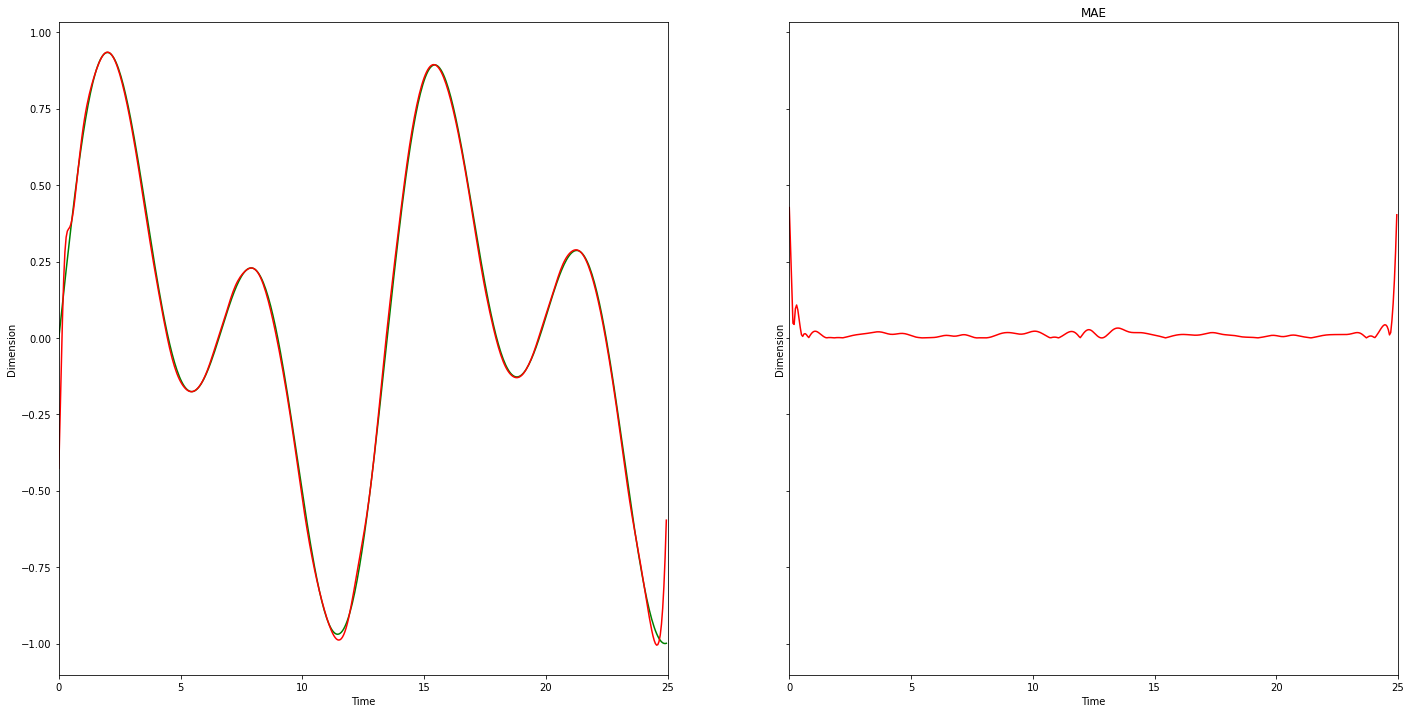

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(24,12))


ax1.plot(time , f_t  + 2*np.arange(0, f_t.shape[1]), 'g')
ax1.plot(time , z_t_call_2 + 2*np.arange(0, z_t_call_2.shape[1]), 'r');
 
ax1.set_xlim((0, T))
plt.title('Target - f (green), Output - z (red)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Dimension')

ax2.plot(time, tf.math.abs(f_t-z_t_call_2) + 2*np.arange(0, z_t_call_2.shape[1]), 'r');
ax2.set_xlim((0, T))
plt.title('MAE')
ax2.set_xlabel('Time')
ax2.set_ylabel('Dimension')

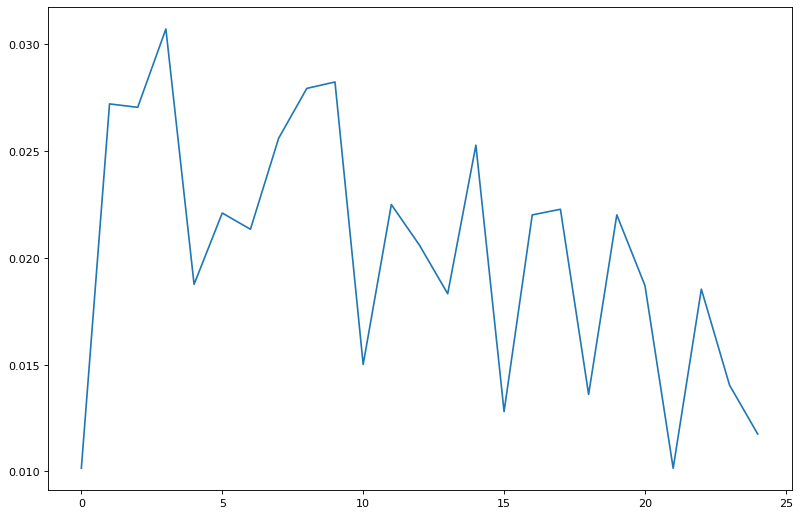

In [22]:
plt.figure(figsize=(12,8), dpi=80)
plt.plot(history2.history['mae'])